# **Analyse de données des ventes électronique**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import chardet

In [2]:
def detect_encoding(file_path):
    """
    Détecte l'encodage du fichier.
    """
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    return chardet.detect(raw_data)['encoding']

def load_and_clean_data(file_path):
    """
    Charge et nettoie les données à partir d'un fichier CSV.
    """
    encoding = detect_encoding(file_path)
    df = pd.read_csv(file_path, encoding=encoding)
    
    # Convertir les colonnes de dates en datetime
    date_columns = ['Order Date', 'Delivery Date', 'Birthday', 'Open Date', 'Date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    # Nettoyer les colonnes monétaires
    money_columns = ['Unit Cost USD', 'Unit Price USD']
    for col in money_columns:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    
    return df

def load_all_data():
    """
    Charge tous les fichiers de données et retourne un dictionnaire de dataframes.
    """
    files = ['Sales.csv', 'Products.csv', 'Customers.csv', 'Stores.csv', 'Exchange_Rates.csv']
    data = {}
    
    for file in files:
        name = file.split('.')[0].lower()
        data[name] = load_and_clean_data(f'Data/{file}')
    
    return data

def merge_sales_data(data):
    """
    Fusionne les données de ventes avec les informations sur les produits, clients et magasins.
    """
    sales = data['sales']
    sales = sales.merge(data['products'], on='ProductKey', how='left')
    sales = sales.merge(data['customers'], on='CustomerKey', how='left')
    sales = sales.merge(data['stores'], on='StoreKey', how='left')
    
    # Ajouter le taux de change
    sales = sales.merge(data['exchange_rates'], left_on=['Order Date', 'Currency Code'], 
                        right_on=['Date', 'Currency'], how='left')
    
    # Calculer le montant en USD
    sales['Amount USD'] = sales['Quantity'] * sales['Unit Price USD']
    sales['Amount Local'] = sales['Amount USD'] * sales['Exchange']
    
    return sales

def calculate_delivery_time(sales):
    """
    Calcule le temps de livraison en jours.
    """
    sales['Delivery Time'] = (sales['Delivery Date'] - sales['Order Date']).dt.days
    return sales

In [3]:
# Exemple d'utilisation
if __name__ == "__main__":
    data = load_all_data()
    merged_sales = merge_sales_data(data)
    merged_sales = calculate_delivery_time(merged_sales)
    print(merged_sales.head())
    print(merged_sales.columns)

   Order Number  Line Item Order Date Delivery Date  CustomerKey  StoreKey  \
0        366000          1 2016-01-01           NaT       265598        10   
1        366001          1 2016-01-01    2016-01-13      1269051         0   
2        366001          2 2016-01-01    2016-01-13      1269051         0   
3        366002          1 2016-01-01    2016-01-12       266019         0   
4        366002          2 2016-01-01    2016-01-12       266019         0   

   ProductKey  Quantity Currency Code                            Product Name  \
0        1304         1           CAD         Contoso Lens Adapter M450 White   
1        1048         2           USD         A. Datum SLR Camera X136 Silver   
2        2007         1           USD  Fabrikam Microwave 1.5CuFt X1100 Black   
3        1106         7           CAD          Contoso SLR Camera M146 Orange   
4         373         1           CAD   Adventure Works Laptop8.9 E0890 White   

   ... Country_y  State_y  Square Meters  Op

In [4]:
# Analyse des produits vendus et de la répartition géographique des clients
#from utils import load_all_data, merge_sales_data
# Chargement des données
data = load_all_data()
merged_sales = merge_sales_data(data)
# Résolution du problème des colonnes dupliquées
merged_sales = merged_sales.rename(columns={'Country_x': 'Country'})

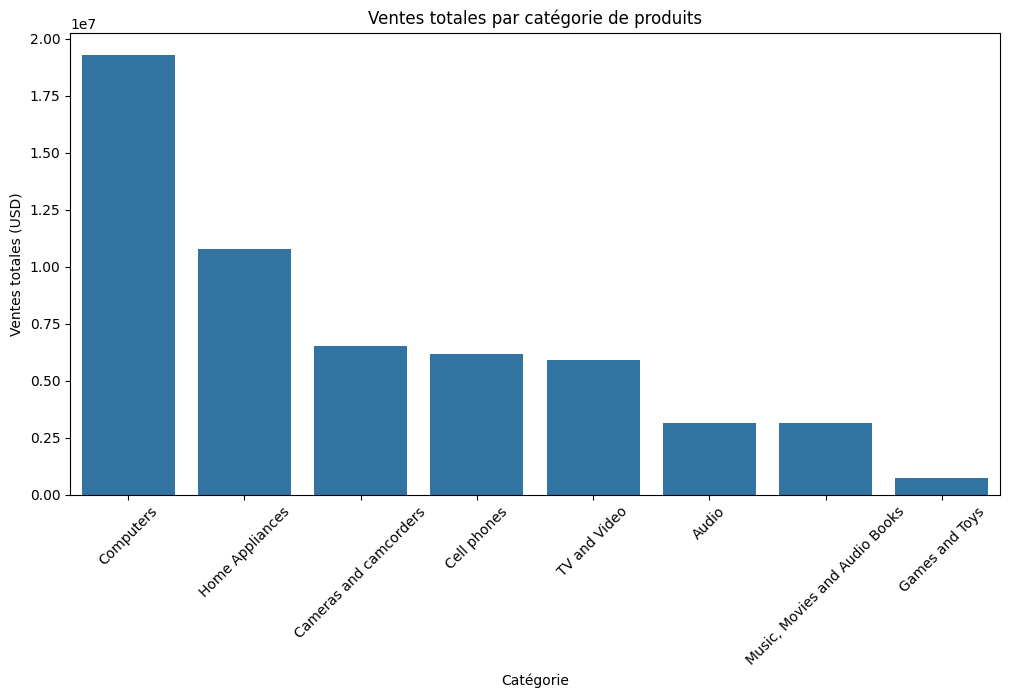

In [5]:
# 1. Analyse des types de produits vendus

## 1.1 Distribution des ventes par catégorie de produits
category_sales = merged_sales.groupby('Category')['Amount USD'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=category_sales.index, y=category_sales.values)
plt.title('Ventes totales par catégorie de produits')
plt.xlabel('Catégorie')
plt.ylabel('Ventes totales (USD)')
plt.xticks(rotation=45)
plt.savefig("imgs/ventes_total_par_categ_prod.png")
plt.show()

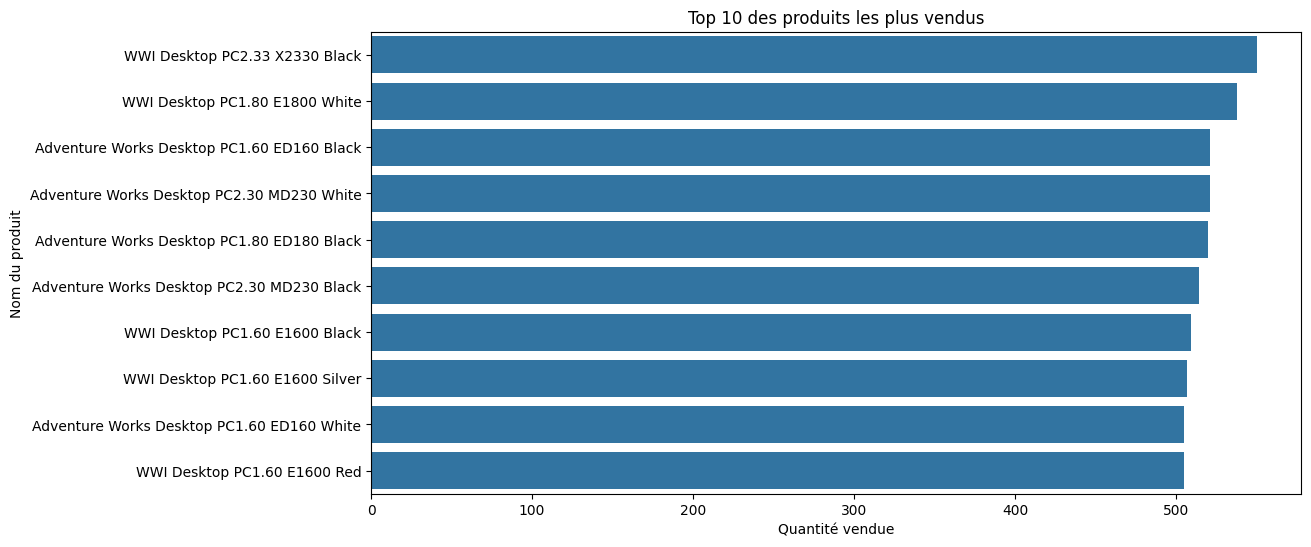

In [6]:
## 1.2 Top 10 des produits les plus vendus
top_products = merged_sales.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 des produits les plus vendus')
plt.xlabel('Quantité vendue')
plt.ylabel('Nom du produit')
plt.savefig("imgs/top10_produits_vendus.png")
plt.show()

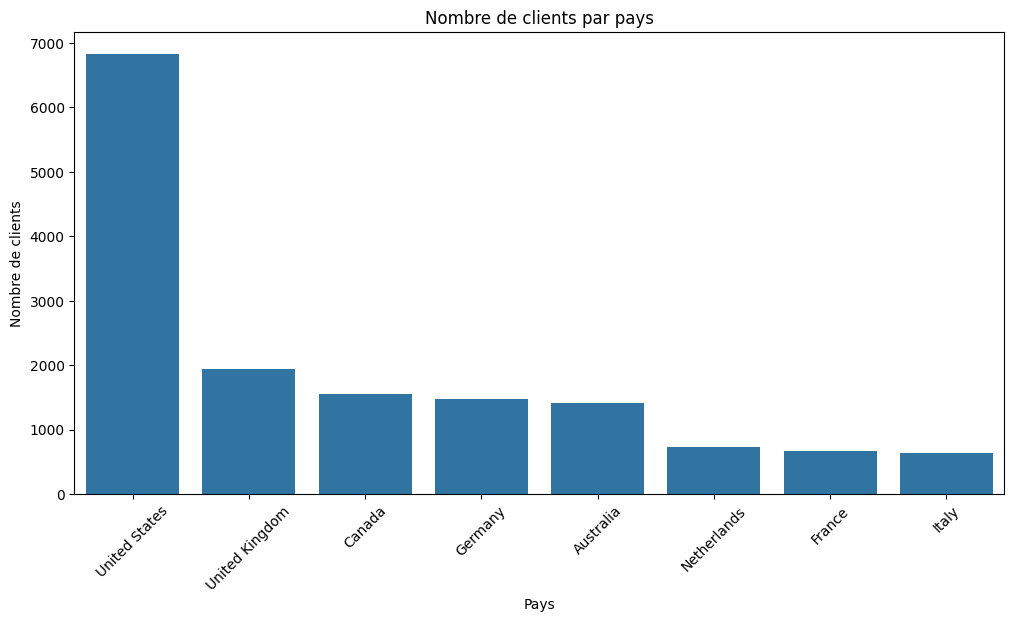

In [7]:
# 2. Répartition géographique des clients

## 2.1 Nombre de clients par pays
customers_by_country = data['customers']['Country'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=customers_by_country.index, y=customers_by_country.values)
plt.title('Nombre de clients par pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.savefig("imgs/nombre_clients_par_pays.png")
plt.show()

In [8]:
## 2.2 Carte choroplèthe des ventes par pays
sales_by_country = merged_sales.groupby('Country')['Amount USD'].sum().reset_index()

fig = px.choropleth(sales_by_country, 
                    locations='Country', 
                    locationmode='country names',
                    color='Amount USD', 
                    hover_name='Country', 
                    color_continuous_scale='Viridis')

fig.update_layout(title='Répartition des ventes par pays')

In [9]:
# Utilisation de .write_html() au lieu de .show()
fig.write_html("imgs/sales_by_country_map.html")
#print("La carte des ventes par pays a été sauvegardée dans 'sales_by_country_map.html'")

# Affichage des données brutes pour vérification
print(sales_by_country.sort_values('Amount USD', ascending=False).head())

# 3. Analyse croisée : Catégories de produits les plus populaires par pays
top_categories_by_country = merged_sales.groupby(['Country', 'Category'])['Amount USD'].sum().reset_index()
top_categories_by_country = top_categories_by_country.sort_values(['Country', 'Amount USD'], ascending=[True, False])
top_categories_by_country = top_categories_by_country.groupby('Country').first().reset_index()

          Country   Amount USD
7   United States  29871631.17
6  United Kingdom   7084088.12
3         Germany   5414149.80
1          Canada   4724334.63
0       Australia   2708137.61


In [10]:
fig = px.choropleth(top_categories_by_country, 
                    locations='Country', 
                    locationmode='country names',
                    color='Category', 
                    hover_name='Country', 
                    hover_data=['Amount USD'])

fig.update_layout(title='Catégorie de produit la plus vendue par pays')

In [11]:
# Utilisation de .write_html() au lieu de .show()
fig.write_html("imgs/top_categories_by_country_map.html")
#print("La carte des catégories les plus vendues par pays a été sauvegardée dans 'top_categories_by_country_map.html'")

In [12]:
# Affichage des données brutes pour vérification
print(top_categories_by_country.head())

     Country   Category  Amount USD
0  Australia  Computers   857960.80
1     Canada  Computers  1653008.10
2     France  Computers   559149.03
3    Germany  Computers  1930179.90
4      Italy  Computers   847064.68


In [13]:
# Conclusions et insights
#print("Insights sur les produits vendus et la répartition géographique des clients :")
#print("1. Les catégories de produits les plus vendues sont...")
#print("2. Les pays avec le plus grand nombre de clients sont...")
#print("3. Les pays générant le plus de ventes sont...")
#print("4. On observe une préférence pour la catégorie ... dans la plupart des pays.")

In [14]:
# Analyse des tendances temporelles et saisonnières des ventes

# Assurons-nous que la colonne 'Order Date' est bien en format datetime
merged_sales['Order Date'] = pd.to_datetime(merged_sales['Order Date'])

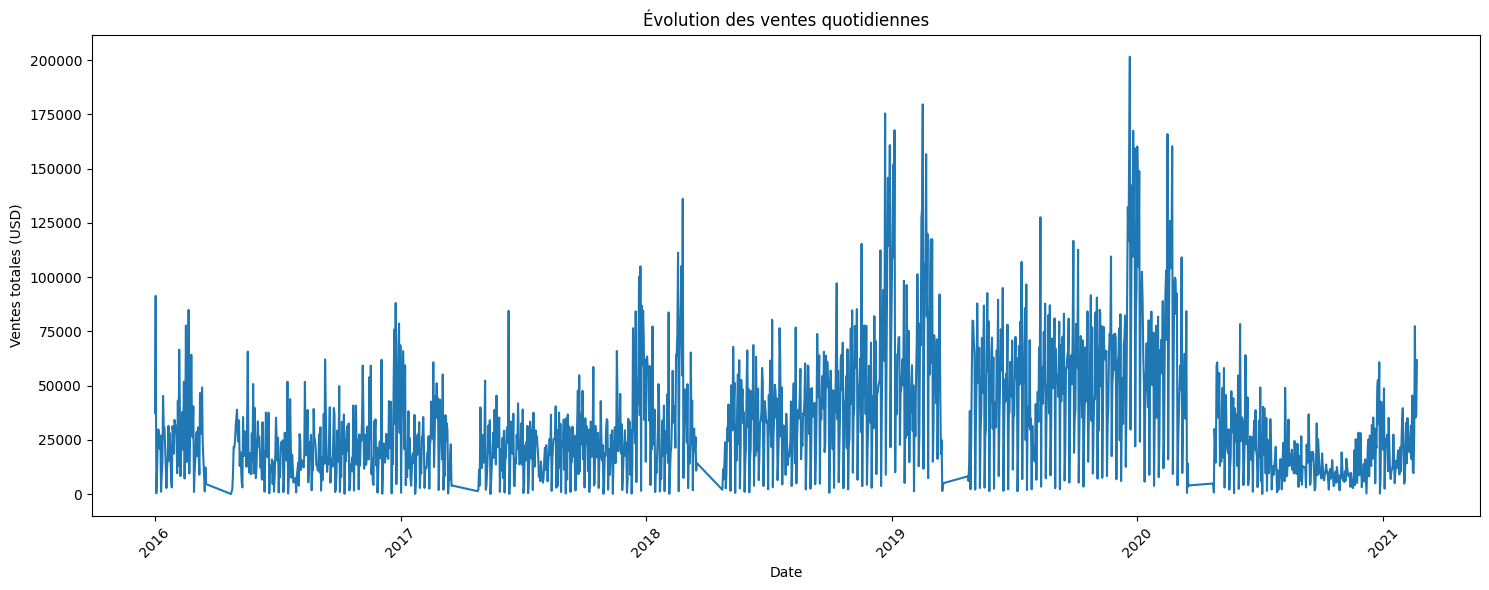

In [15]:
# 1. Tendance générale des ventes au fil du temps

# Agrégation des ventes par jour
daily_sales = merged_sales.groupby('Order Date')['Amount USD'].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Order Date'], daily_sales['Amount USD'])
plt.title('Évolution des ventes quotidiennes')
plt.xlabel('Date')
plt.ylabel('Ventes totales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/evolution_des_ventes_quotidiennes.png")
plt.show()

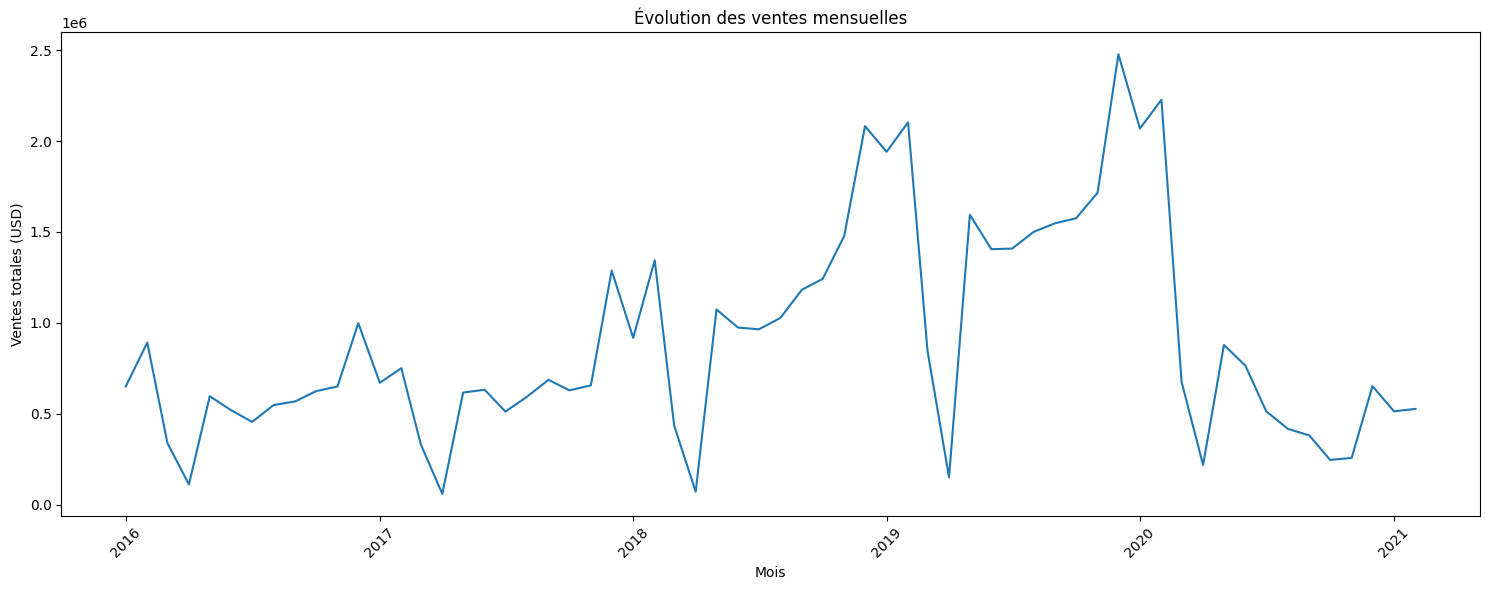

In [16]:
# 2. Analyse des ventes mensuelles

# Agrégation des ventes par mois
monthly_sales = merged_sales.groupby(merged_sales['Order Date'].dt.to_period('M'))['Amount USD'].sum().reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales['Order Date'], monthly_sales['Amount USD'])
plt.title('Évolution des ventes mensuelles')
plt.xlabel('Mois')
plt.ylabel('Ventes totales (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/evolution_des_ventes_mensuelles.png")
plt.show()

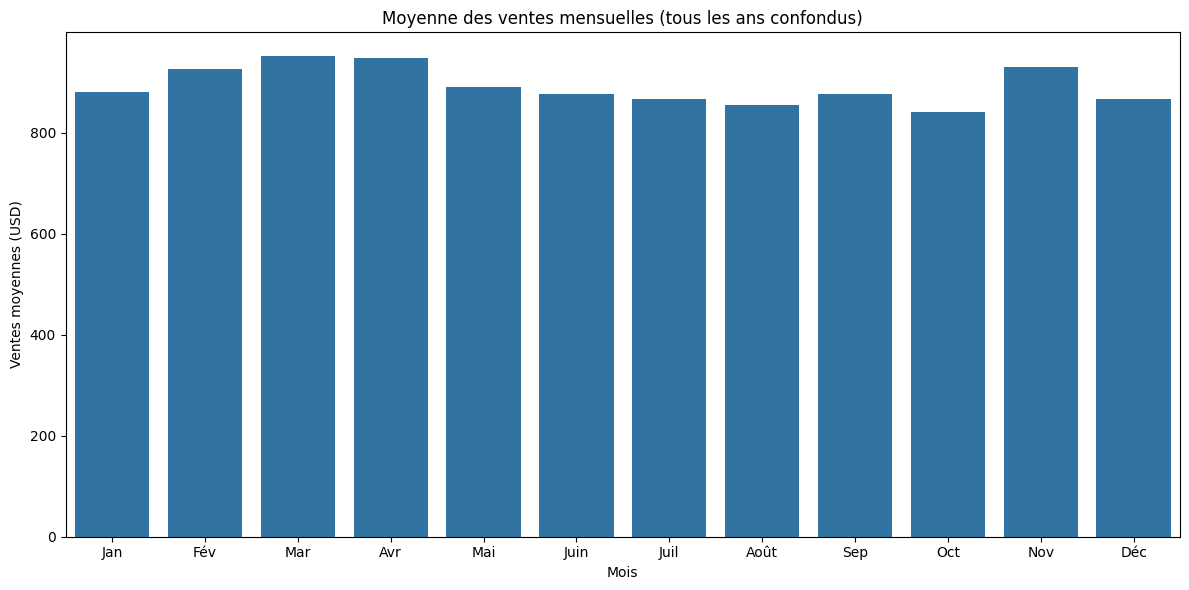

In [17]:
# 3. Analyse saisonnière

# Ajout des colonnes pour le mois et l'année
merged_sales['Month'] = merged_sales['Order Date'].dt.month
merged_sales['Year'] = merged_sales['Order Date'].dt.year

# Agrégation des ventes par mois (tous les ans confondus)
seasonal_sales = merged_sales.groupby('Month')['Amount USD'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Amount USD', data=seasonal_sales)
plt.title('Moyenne des ventes mensuelles (tous les ans confondus)')
plt.xlabel('Mois')
plt.ylabel('Ventes moyennes (USD)')
plt.xticks(range(12), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.tight_layout()
plt.savefig("imgs/moyenne_ventes_mensuelles.png")
plt.show()

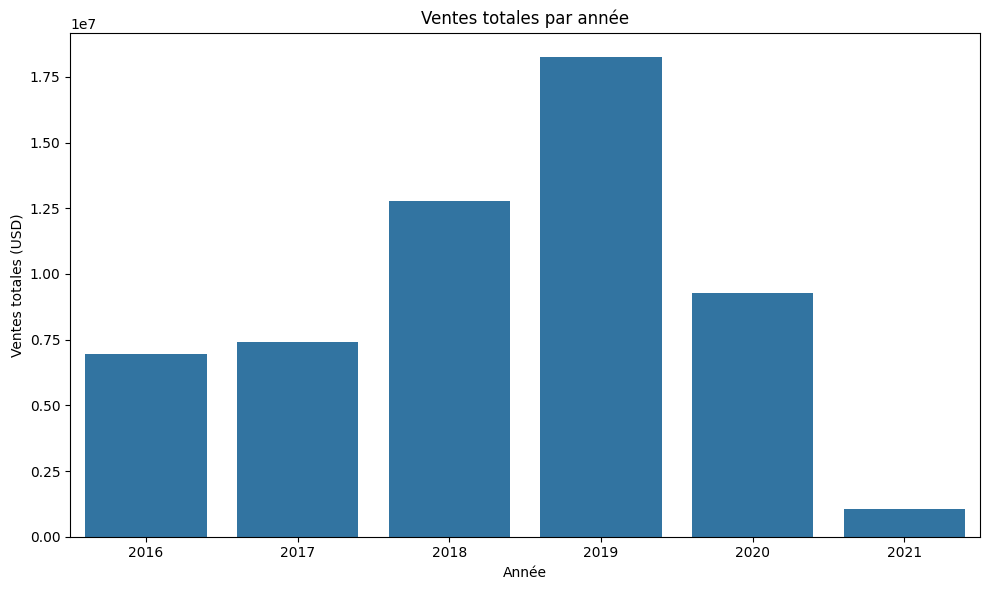

In [18]:
# 4. Comparaison des ventes annuelles

yearly_sales = merged_sales.groupby('Year')['Amount USD'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Amount USD', data=yearly_sales)
plt.title('Ventes totales par année')
plt.xlabel('Année')
plt.ylabel('Ventes totales (USD)')
plt.tight_layout()
plt.savefig("imgs/ventes_totale_par_an.png")
plt.show()

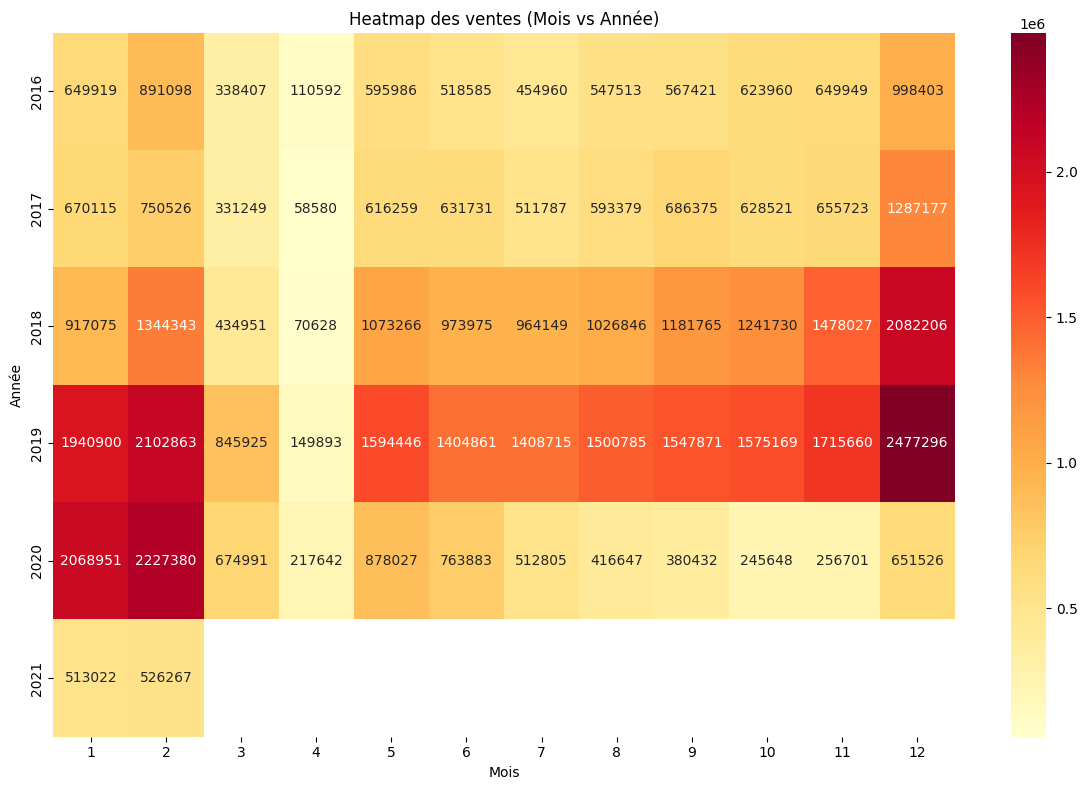

In [19]:
# 5. Heatmap des ventes (Mois vs Année)

sales_heatmap = merged_sales.groupby(['Year', 'Month'])['Amount USD'].sum().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(sales_heatmap, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Heatmap des ventes (Mois vs Année)')
plt.xlabel('Mois')
plt.ylabel('Année')
plt.tight_layout()
plt.savefig("imgs/heatmap_ventes_mois_annee.png")
plt.show()

In [20]:
# Conclusions et insights
#print("Insights sur les tendances temporelles et saisonnières des ventes :")
#print("1. La tendance générale des ventes montre...")
#print("2. Les mois avec les ventes les plus élevées sont généralement...")
#print("3. On observe une saisonnalité marquée par...")
#print("4. L'évolution des ventes d'une année à l'autre indique...")
#print("5. Les périodes qui nécessitent une attention particulière sont...")

## **Analyse des délais de livraison**

In [21]:
# Chargement et préparation des données
data = load_all_data()
merged_sales = merge_sales_data(data)
merged_sales = calculate_delivery_time(merged_sales)

In [22]:
# Filtrer les lignes avec des délais de livraison valides
valid_deliveries = merged_sales[merged_sales['Delivery Time'].notna() & (merged_sales['Delivery Time'] >= 0)]

Le délai de livraison moyen global est de 4.53 jours.


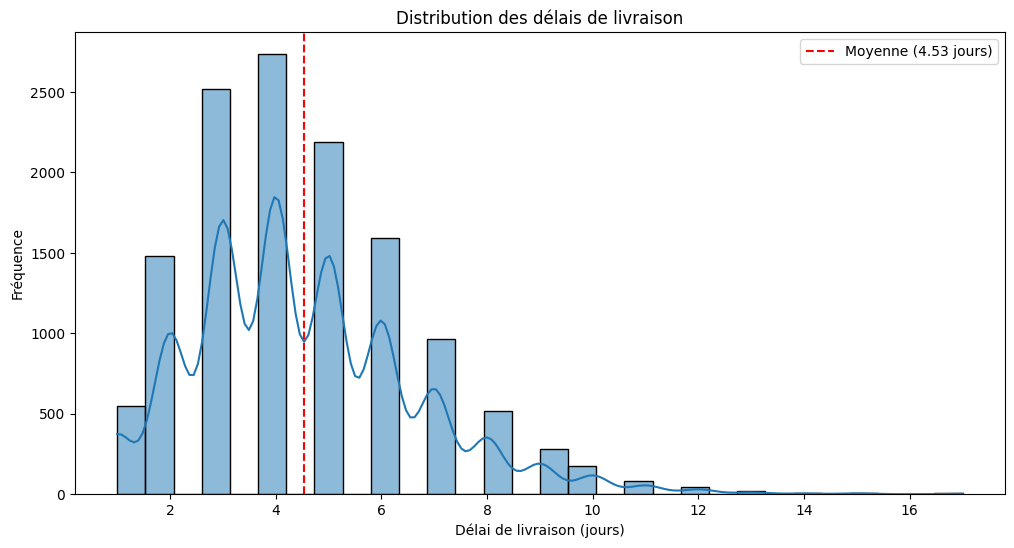

In [23]:
# 1. Délai de livraison moyen global
average_delivery_time = valid_deliveries['Delivery Time'].mean()

print(f"Le délai de livraison moyen global est de {average_delivery_time:.2f} jours.")

# 2. Distribution des délais de livraison
plt.figure(figsize=(12, 6))
sns.histplot(valid_deliveries['Delivery Time'], bins=30, kde=True)
plt.title('Distribution des délais de livraison')
plt.xlabel('Délai de livraison (jours)')
plt.ylabel('Fréquence')
plt.axvline(average_delivery_time, color='r', linestyle='--', label=f'Moyenne ({average_delivery_time:.2f} jours)')
plt.legend()
plt.savefig("imgs/distribution_delais_livraison.png")
plt.show()

In [24]:
# Filtrer les lignes avec des délais de livraison valides
valid_deliveries = merged_sales[merged_sales['Delivery Time'].notna() & (merged_sales['Delivery Time'] >= 0)]

# 1. Délai de livraison moyen global
average_delivery_time = valid_deliveries['Delivery Time'].mean()

print(f"Le délai de livraison moyen global est de {average_delivery_time:.2f} jours.")

Le délai de livraison moyen global est de 4.53 jours.


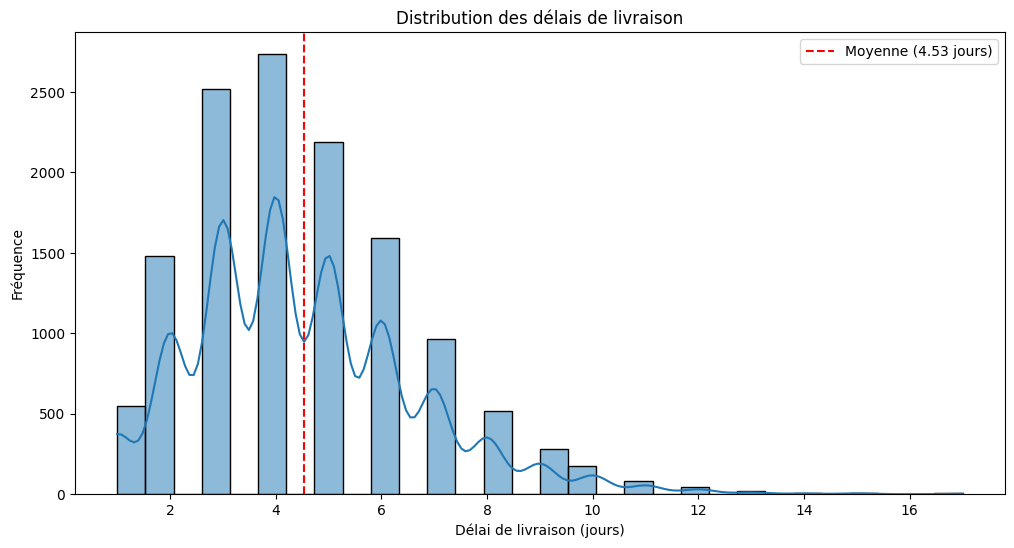

In [25]:
# 2. Distribution des délais de livraison
plt.figure(figsize=(12, 6))
sns.histplot(valid_deliveries['Delivery Time'], bins=30, kde=True)
plt.title('Distribution des délais de livraison')
plt.xlabel('Délai de livraison (jours)')
plt.ylabel('Fréquence')
plt.axvline(average_delivery_time, color='r', linestyle='--', label=f'Moyenne ({average_delivery_time:.2f} jours)')
plt.legend()
plt.show()

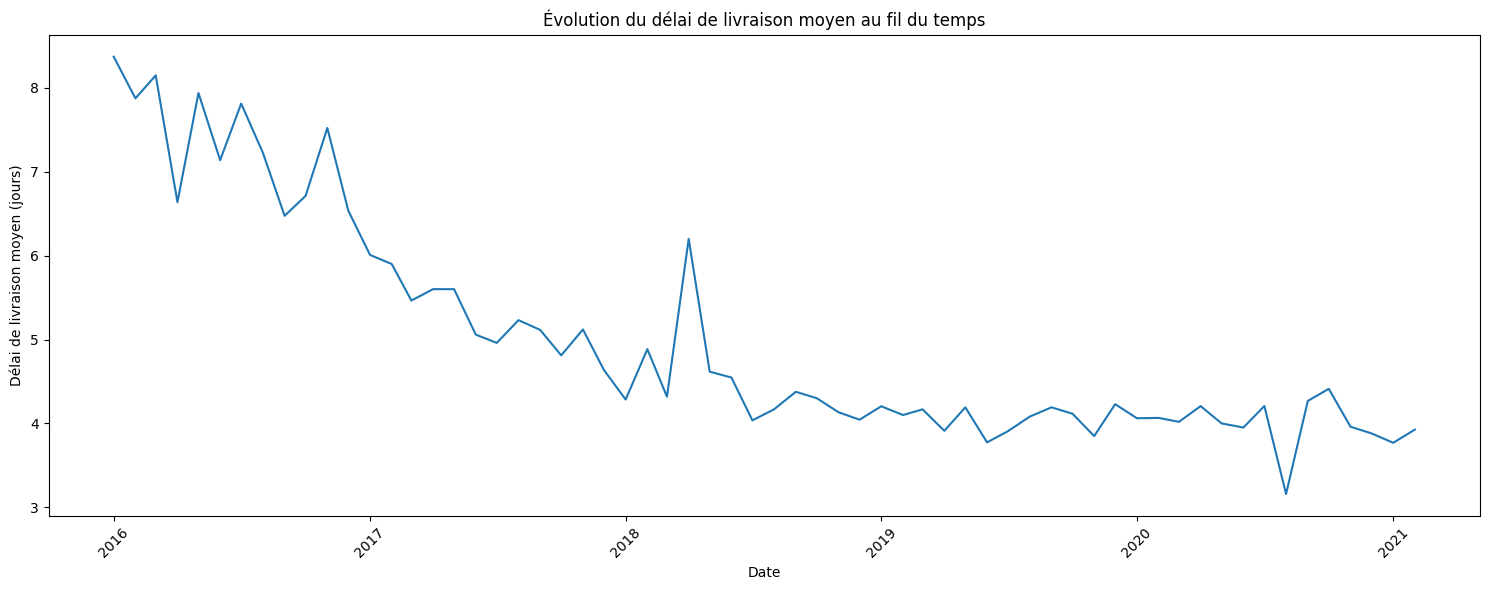

In [26]:
# 3. Évolution du délai de livraison moyen au fil du temps
monthly_avg_delivery_time = valid_deliveries.groupby(valid_deliveries['Order Date'].dt.to_period('M'))['Delivery Time'].mean().reset_index()
monthly_avg_delivery_time['Order Date'] = monthly_avg_delivery_time['Order Date'].dt.to_timestamp()

plt.figure(figsize=(15, 6))
plt.plot(monthly_avg_delivery_time['Order Date'], monthly_avg_delivery_time['Delivery Time'])
plt.title('Évolution du délai de livraison moyen au fil du temps')
plt.xlabel('Date')
plt.ylabel('Délai de livraison moyen (jours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/evol_delai_livr_moyen_temps.png")
plt.show()

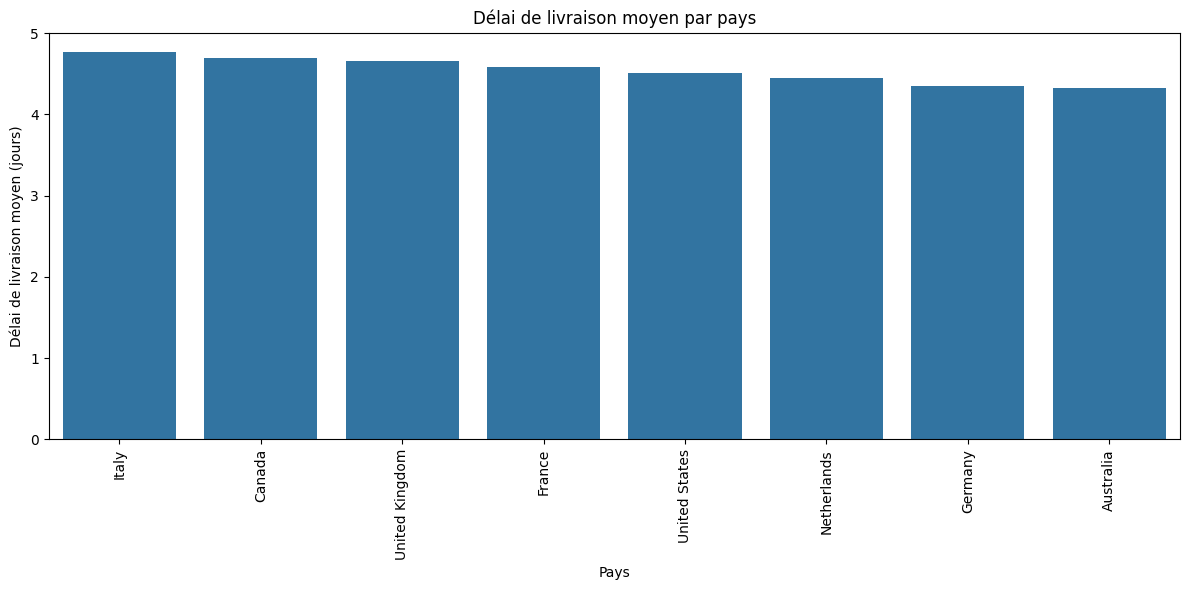

In [27]:
# 4. Délai de livraison moyen par pays
valid_deliveries = valid_deliveries.rename(columns={'Country_x': 'Country'}) # renom...
avg_delivery_time_by_country = valid_deliveries.groupby('Country')['Delivery Time'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_delivery_time_by_country.index, y=avg_delivery_time_by_country.values)
plt.title('Délai de livraison moyen par pays')
plt.xlabel('Pays')
plt.ylabel('Délai de livraison moyen (jours)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("imgs/delai_livraison_moyen_pays.png")
plt.show()

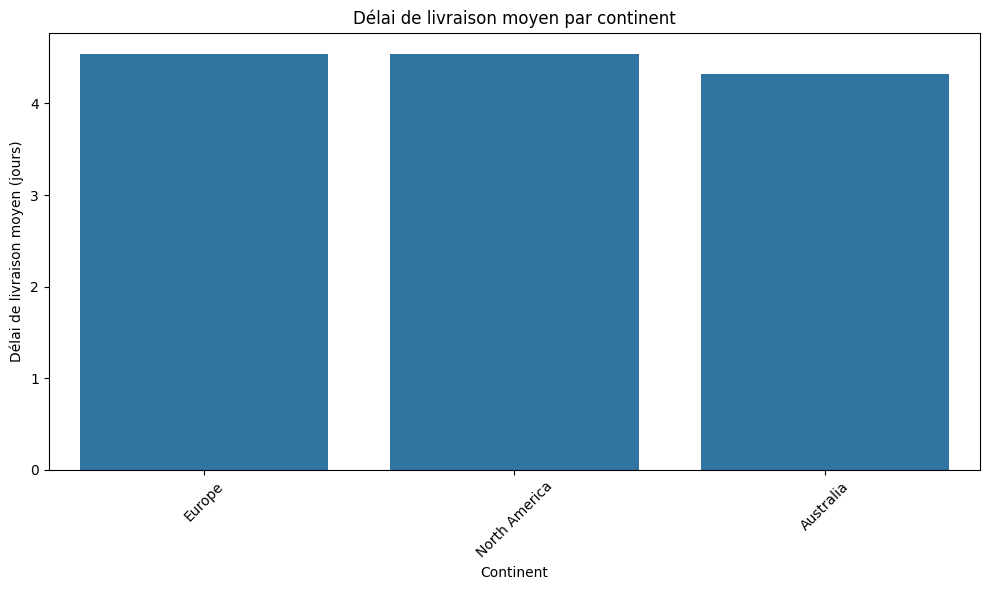

In [28]:
# 5. Relation entre le délai de livraison et la distance (en utilisant le continent comme proxy)
avg_delivery_time_by_continent = valid_deliveries.groupby('Continent')['Delivery Time'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delivery_time_by_continent.index, y=avg_delivery_time_by_continent.values)
plt.title('Délai de livraison moyen par continent')
plt.xlabel('Continent')
plt.ylabel('Délai de livraison moyen (jours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/delai_livraison_moyen_continent.png")
plt.show()

C:\Users\DIALO\AppData\Local\Temp\ipykernel_13968\1026983686.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



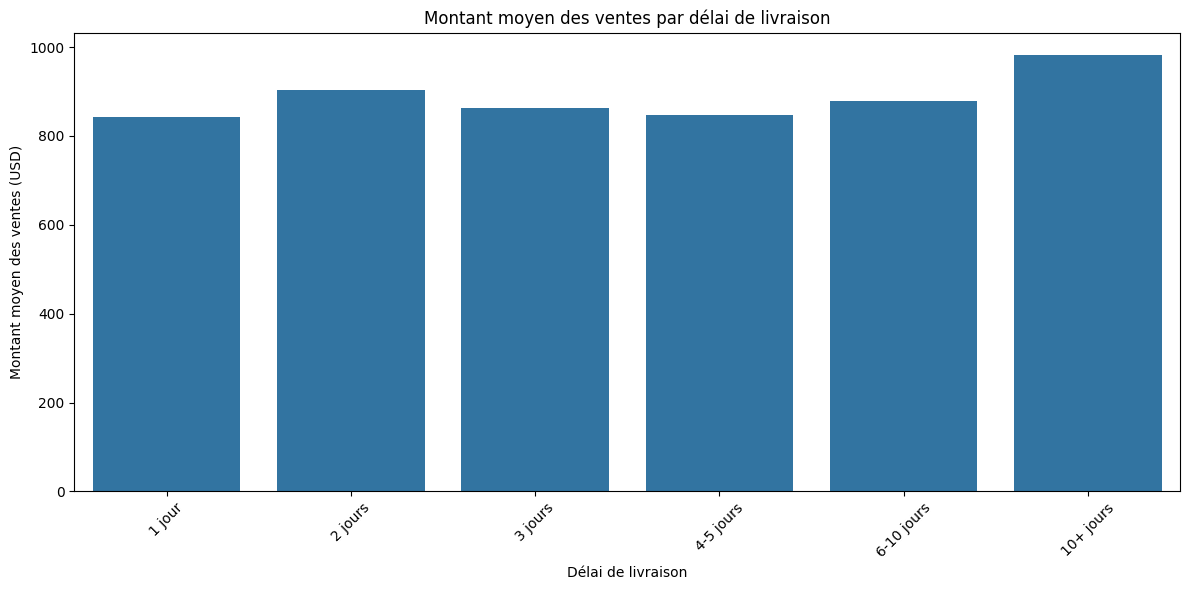

In [29]:
# 6. Impact du délai de livraison sur les ventes
valid_deliveries['Delivery Time Bin'] = pd.cut(valid_deliveries['Delivery Time'], bins=[0, 1, 2, 3, 5, 10, float('inf')], labels=['1 jour', '2 jours', '3 jours', '4-5 jours', '6-10 jours', '10+ jours'])
sales_by_delivery_time = valid_deliveries.groupby('Delivery Time Bin')['Amount USD'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Delivery Time Bin', y='Amount USD', data=sales_by_delivery_time)
plt.title('Montant moyen des ventes par délai de livraison')
plt.xlabel('Délai de livraison')
plt.ylabel('Montant moyen des ventes (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/montant_moyen_ventes_delais_livraison.png")
plt.show()

In [30]:
# Conclusions et insights
#print("\nInsights sur les délais de livraison :")
#print("1. Le délai de livraison moyen global est de...")
#print("2. La distribution des délais de livraison montre...")
#print("3. L'évolution du délai de livraison au fil du temps indique...")
#print("4. Les pays avec les délais de livraison les plus longs sont...")
#print("5. On observe une relation entre la distance (continent) et le délai de livraison...")
#print("6. L'impact du délai de livraison sur les ventes suggère...")

## **Comparaison des ventes en ligne et en magasin**

In [31]:
# Chargement et préparation des données
data = load_all_data()
merged_sales = merge_sales_data(data)

# Identification des ventes en ligne et en magasin
merged_sales['Channel'] = merged_sales['StoreKey'].apply(lambda x: 'En ligne' if x == 0 else 'En magasin')

# 1. Comparaison de la valeur moyenne des commandes (AOV)
aov_by_channel = merged_sales.groupby('Channel')['Amount USD'].mean()

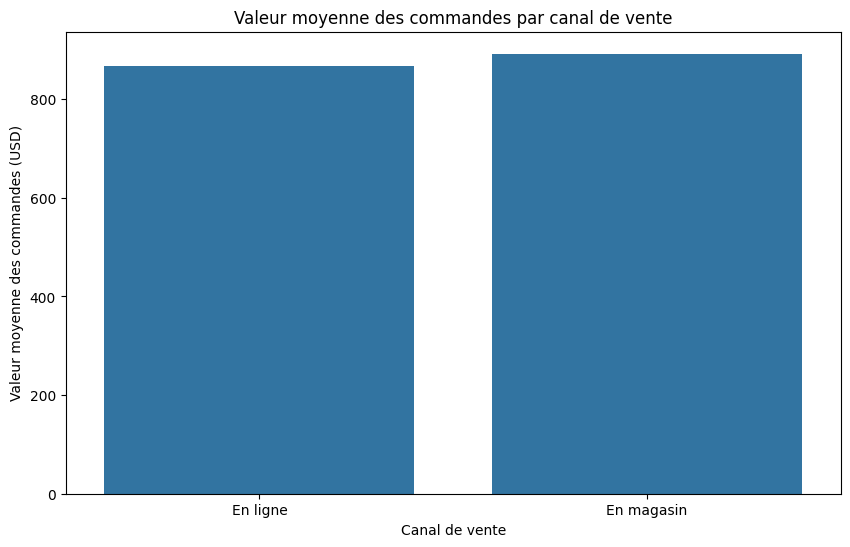

AOV par canal de vente:
Channel
En ligne      866.260891
En magasin    892.036343
Name: Amount USD, dtype: float64


In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x=aov_by_channel.index, y=aov_by_channel.values)
plt.title('Valeur moyenne des commandes par canal de vente')
plt.xlabel('Canal de vente')
plt.ylabel('Valeur moyenne des commandes (USD)')
plt.savefig("imgs/val_moyen_cdes_canal_ventes.png")
plt.show()

print("AOV par canal de vente:")
print(aov_by_channel)

C:\Users\DIALO\AppData\Local\Temp\ipykernel_13968\2707349218.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



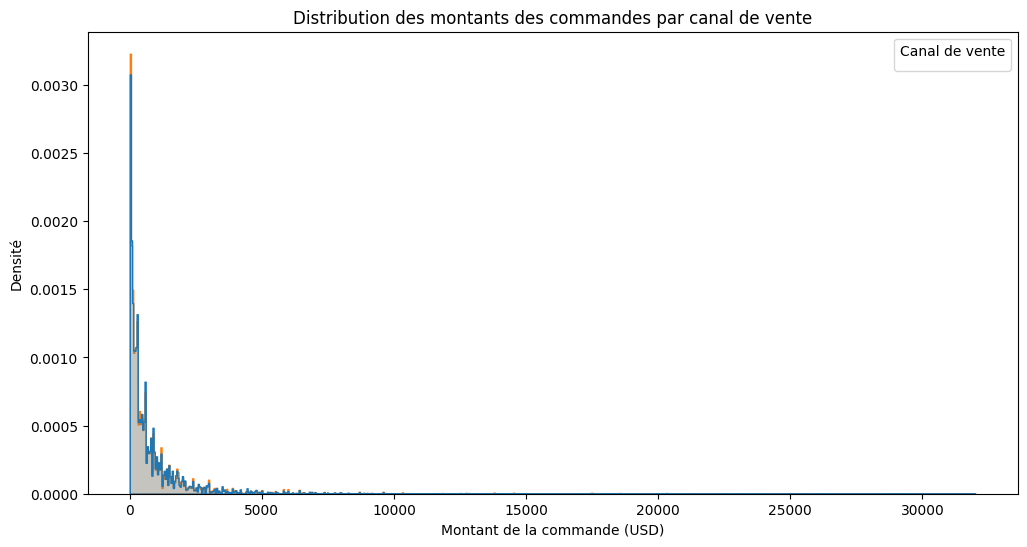

In [33]:
# 2. Distribution des montants des commandes par canal
plt.figure(figsize=(12, 6))
sns.histplot(data=merged_sales, x='Amount USD', hue='Channel', element='step', stat='density', common_norm=False)
plt.title('Distribution des montants des commandes par canal de vente')
plt.xlabel('Montant de la commande (USD)')
plt.ylabel('Densité')
plt.legend(title='Canal de vente')
plt.savefig("imgs/dist_mtant_cdes_canal_vente.png")
plt.show()

<Figure size 800x1200 with 0 Axes>

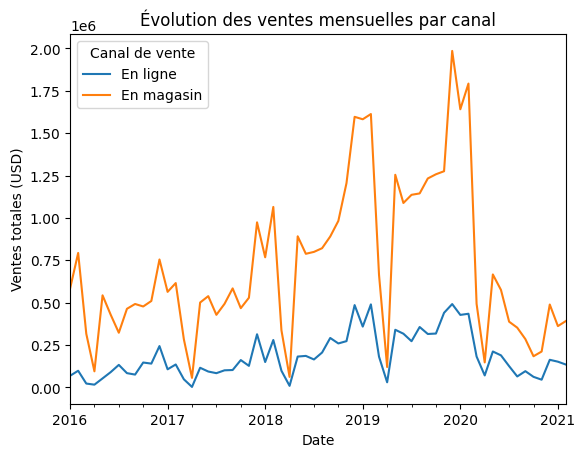

In [34]:
# 3. Évolution des ventes par canal au fil du temps
monthly_sales_by_channel = merged_sales.groupby([merged_sales['Order Date'].dt.to_period('M'), 'Channel'])['Amount USD'].sum().unstack()
monthly_sales_by_channel.index = monthly_sales_by_channel.index.to_timestamp()

plt.figure(figsize=(8, 12))
monthly_sales_by_channel.plot(kind='line')
plt.title('Évolution des ventes mensuelles par canal')
plt.xlabel('Date')
plt.ylabel('Ventes totales (USD)')
plt.legend(title='Canal de vente')
plt.savefig("imgs/evol_ventes_mensuel_canal.png")
plt.show()

<Figure size 1200x800 with 0 Axes>

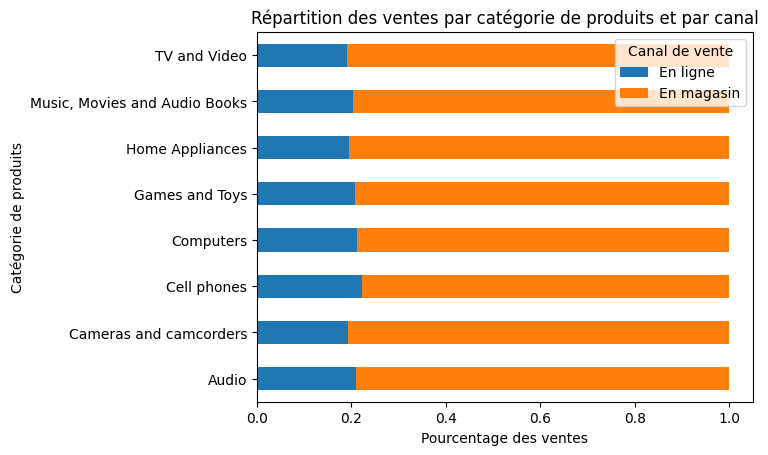

In [35]:
# 4. Répartition des ventes par catégorie de produits et par canal
category_sales_by_channel = merged_sales.groupby(['Category', 'Channel'])['Amount USD'].sum().unstack()
category_sales_by_channel_pct = category_sales_by_channel.div(category_sales_by_channel.sum(axis=1), axis=0)

plt.figure(figsize=(12, 8))
category_sales_by_channel_pct.plot(kind='barh', stacked=True)
plt.title('Répartition des ventes par catégorie de produits et par canal')
plt.xlabel('Pourcentage des ventes')
plt.ylabel('Catégorie de produits')
plt.legend(title='Canal de vente')
plt.savefig("imgs/repart_ventes_categ_prod_canal.png")
plt.show()

In [36]:
# 5. Comparaison des taux de conversion (si possible)
if 'ConversionFlag' in merged_sales.columns:
    conversion_rates = merged_sales.groupby('Channel')['ConversionFlag'].mean()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
    plt.title('Taux de conversion par canal de vente')
    plt.xlabel('Canal de vente')
    plt.ylabel('Taux de conversion')
plt.savefig("imgs/taux_de_conversion.png")
    plt.show()
else:
    print("Les données sur les taux de conversion ne sont pas disponibles.")

Les données sur les taux de conversion ne sont pas disponibles.


C:\Users\DIALO\AppData\Local\Temp\ipykernel_13968\1599189925.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1200x600 with 0 Axes>

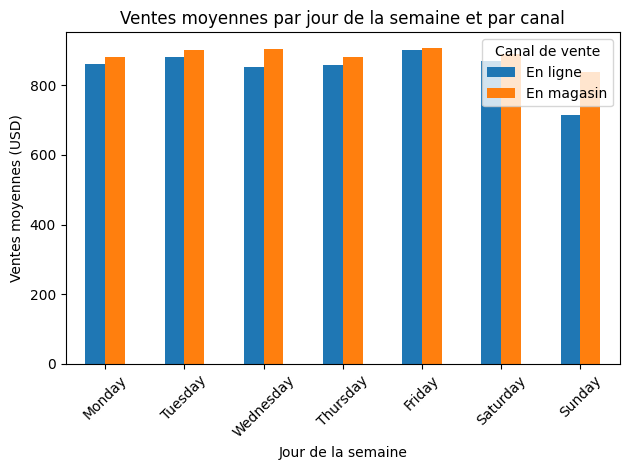

In [37]:
# 6. Analyse des ventes par jour de la semaine et par canal
merged_sales['DayOfWeek'] = merged_sales['Order Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_sales['DayOfWeek'] = pd.Categorical(merged_sales['DayOfWeek'], categories=day_order, ordered=True)

daily_sales_by_channel = merged_sales.groupby(['DayOfWeek', 'Channel'])['Amount USD'].mean().unstack()

plt.figure(figsize=(12, 6))
daily_sales_by_channel.plot(kind='bar')
plt.title('Ventes moyennes par jour de la semaine et par canal')
plt.xlabel('Jour de la semaine')
plt.ylabel('Ventes moyennes (USD)')
plt.legend(title='Canal de vente')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("imgs/ventes_moy_jourdelasemaine_canal.png")
plt.show()

In [ ]:
# Conclusions et insights
print("\nInsights sur la comparaison des ventes en ligne et en magasin :")
print("1. La valeur moyenne des commandes (AOV) est...")
print("2. La distribution des montants des commandes montre...")
print("3. L'évolution des ventes au fil du temps indique...")
print("4. Les catégories de produits qui performent mieux en ligne/en magasin sont...")
print("5. Les taux de conversion...")
print("6. Les tendances des ventes par jour de la semaine suggèrent...")